First we load in the cleaned dataset and prepare it by removing the target from the feature set

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import load_iris
import numpy as np



# Load the dataset
file_path = '../dataset/heart_cleaned.csv'  
data = pd.read_csv(file_path)

# Define the feature columns and the target column
# features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'] #all features
#features oldpeak, thalach, cp, exang
features = ['cp','oldpeak','thalach','exang'] #selected features

target = 'target'

#print the first 5 rows of the dataset in table format
print(data.head())



   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   70    1   0       145   174    0        1      125      1      2.6      0   
2   61    1   0       148   203    0        1      161      0      0.0      2   
3   58    0   0       100   248    0        0      122      0      1.0      1   
4   55    1   0       160   289    0        0      145      1      0.8      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   1     3       0  
3   0     2       1  
4   1     3       0  


Now we get a feel for how the DT algorithm performs with default params, the training accuracy is much higher than the test accuracy indicating overfitting

In [53]:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

print("Feature columns:", features)
print("Target column:", target)

# Split the data into training and testing sets
print("Splitting the dataset into training and testing sets...")
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Initialize and train the Decision Tree classifier with default hyperparameters
print("Training the Decision Tree classifier...")
clf = DecisionTreeClassifier(random_state=42, max_depth=None)
clf.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the training set
print("Making predictions on the training set...")
y_train_pred = clf.predict(X_train)

# Evaluate the model on the training set
print("Evaluating the model on the training set...")
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print("Training Classification Report:")
print(train_report)

# Make predictions on the test set
print("Making predictions on the test set...")
y_pred = clf.predict(X_test)
print("Predictions complete. Here are the first 5 predictions:")
print(y_pred[:5])

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print("Test Classification Report:")
print(test_report)


Feature columns: ['cp', 'oldpeak', 'thalach', 'exang']
Target column: target
Splitting the dataset into training and testing sets...
Training set size: 182 samples
Testing set size: 46 samples
Training the Decision Tree classifier...
Model training complete.
Making predictions on the training set...
Evaluating the model on the training set...
Training Accuracy: 0.98
Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        81
           1       0.99      0.98      0.99       101

    accuracy                           0.98       182
   macro avg       0.98      0.98      0.98       182
weighted avg       0.98      0.98      0.98       182

Making predictions on the test set...
Predictions complete. Here are the first 5 predictions:
[1 0 0 0 1]
Evaluating the model on the test set...
Test Accuracy: 0.78
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63

Now we confirm our results by performing cross validation. The CV scores are much lower than the training accuracy indicating overfitting

In [54]:



# Perform cross-validation
print("Performing cross-validation...")
cv_scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")

# Check for overfitting
if train_accuracy > test_accuracy *1.2:
    print("The model may be overfitting. Consider tuning hyperparameters or pruning the tree.")


Performing cross-validation...
Cross-validation scores: [0.67391304 0.7826087  0.63043478 0.66666667 0.66666667]
Mean cross-validation score: 0.68
The model may be overfitting. Consider tuning hyperparameters or pruning the tree.


Now we visualize the over fitting tree because its cool

Visualizing the Decision Tree...


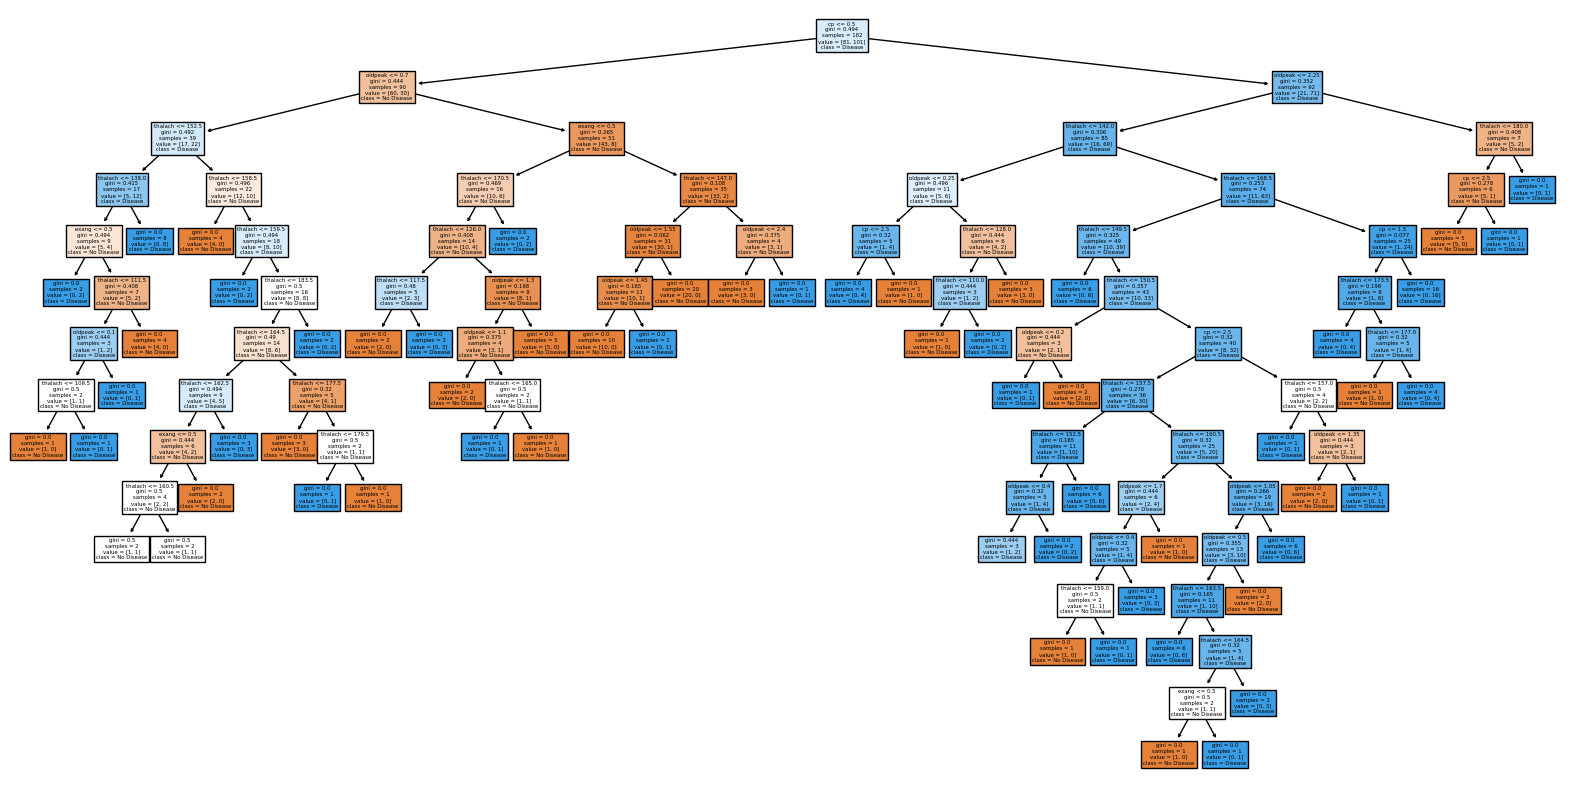

In [55]:


# Visualize the Decision Tree
print("Visualizing the Decision Tree...")
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=features, class_names=["No Disease", "Disease"])
plt.show()

To get a feel for how the hyper parameters effect the training accuracy, test_accuracy, and cv score means we tune the hyper paremters independently one at a time. we can see how values of max_depth above 3.5 produce serious over fitting. similarly low values of min_samples_leaf and min_samples_split produce overfitting

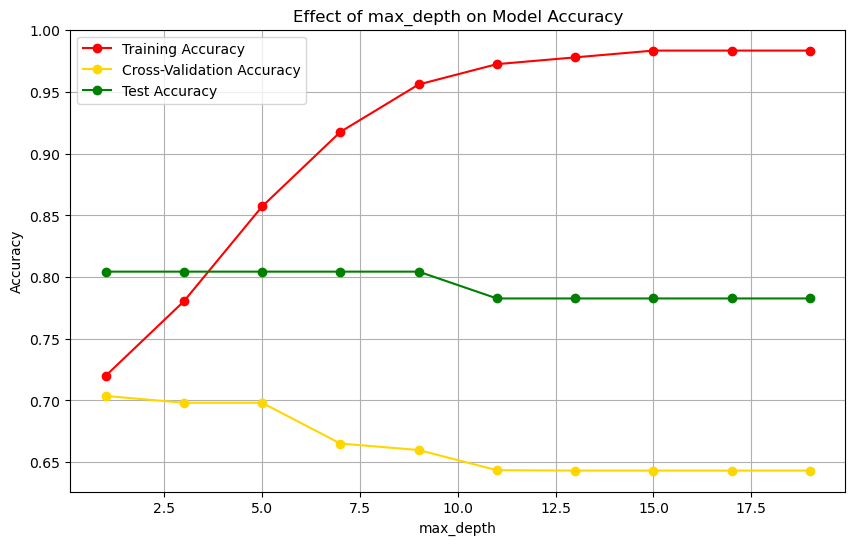

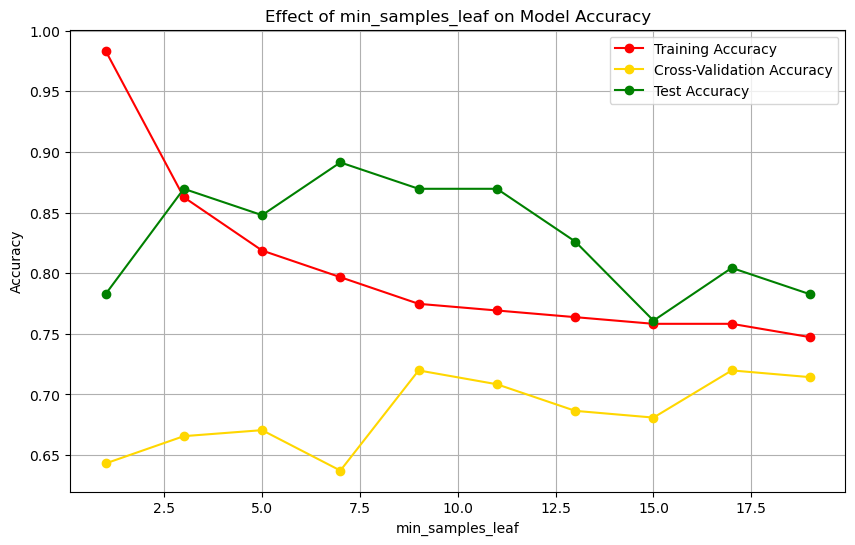

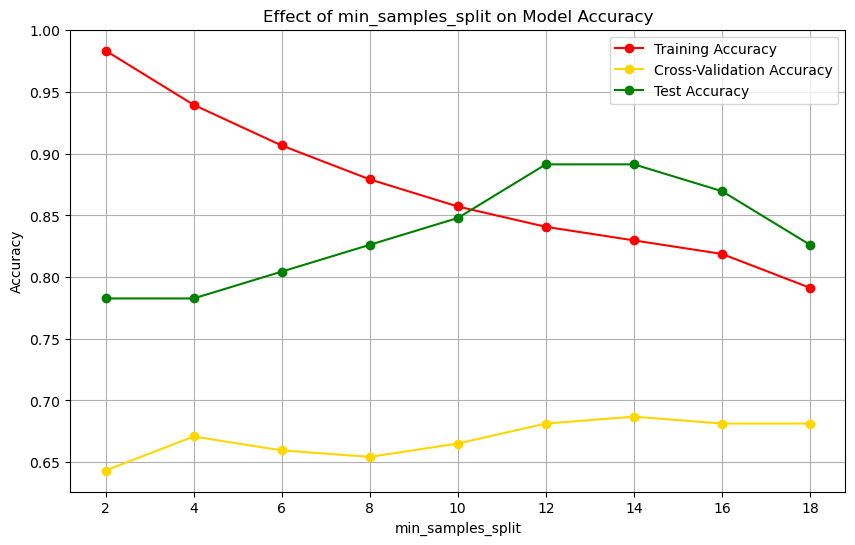

In [59]:
import seaborn as sns
# Function to train and evaluate the model with given hyperparameters
def evaluate_model(max_depth=None, min_samples_split=2, min_samples_leaf=1, cv=5):
    clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # Perform cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Fit the model to the full training data to get training accuracy
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    
    # Evaluate the model on the test set to get test accuracy
    y_pred_test = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Return the training accuracy, mean cross-validation accuracy, and test accuracy
    return train_accuracy, cv_scores.mean(), test_accuracy



param_range = np.arange(1, 20, 2)

# Initialize lists to store the results
train_scores = []
cv_scores = []
test_scores = []

#  Evaluate the model while varying max_depth for each parameter value
for param in param_range:
    train_acc, cv_acc, test_acc = evaluate_model(max_depth=param)
    train_scores.append(train_acc)
    cv_scores.append(cv_acc)
    test_scores.append(test_acc)

# Plotting the results
plt.figure(figsize=(10, 6))

plt.plot(param_range, train_scores, label='Training Accuracy', marker='o', color='red')
plt.plot(param_range, cv_scores, label='Cross-Validation Accuracy', marker='o', color='gold')
plt.plot(param_range, test_scores, label='Test Accuracy', marker='o', color='green')
plt.title('Effect of max_depth on Model Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Reset lists to store the results for min_samples_split
train_scores = []
cv_scores = []
test_scores = []

param_range = np.arange(1, 20, 2)

#  Evaluate the model while varying min_samples_leaf for each parameter value
for param in param_range:
    train_acc, cv_acc, test_acc = evaluate_model(min_samples_leaf=param)
    train_scores.append(train_acc)
    cv_scores.append(cv_acc)
    test_scores.append(test_acc)

# Plotting the results
plt.figure(figsize=(10, 6))

plt.plot(param_range, train_scores, label='Training Accuracy', marker='o', color='red')
plt.plot(param_range, cv_scores, label='Cross-Validation Accuracy', marker='o', color='gold')
plt.plot(param_range, test_scores, label='Test Accuracy', marker='o', color='green')
plt.title('Effect of min_samples_leaf on Model Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Reset lists to store the results for min_samples_split
train_scores = []
cv_scores = []
test_scores = []

param_range = np.arange(2, 20, 2)

#  Evaluate the model while varying max_depth for each parameter value
for param in param_range:
    train_acc, cv_acc, test_acc = evaluate_model(min_samples_split=param)
    train_scores.append(train_acc)
    cv_scores.append(cv_acc)
    test_scores.append(test_acc)

# Plotting the results
plt.figure(figsize=(10, 6))

plt.plot(param_range, train_scores, label='Training Accuracy', marker='o', color='red')
plt.plot(param_range, cv_scores, label='Cross-Validation Accuracy', marker='o', color='gold')
plt.plot(param_range, test_scores, label='Test Accuracy', marker='o', color='green')
plt.title('Effect of min_samples_split on Model Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()






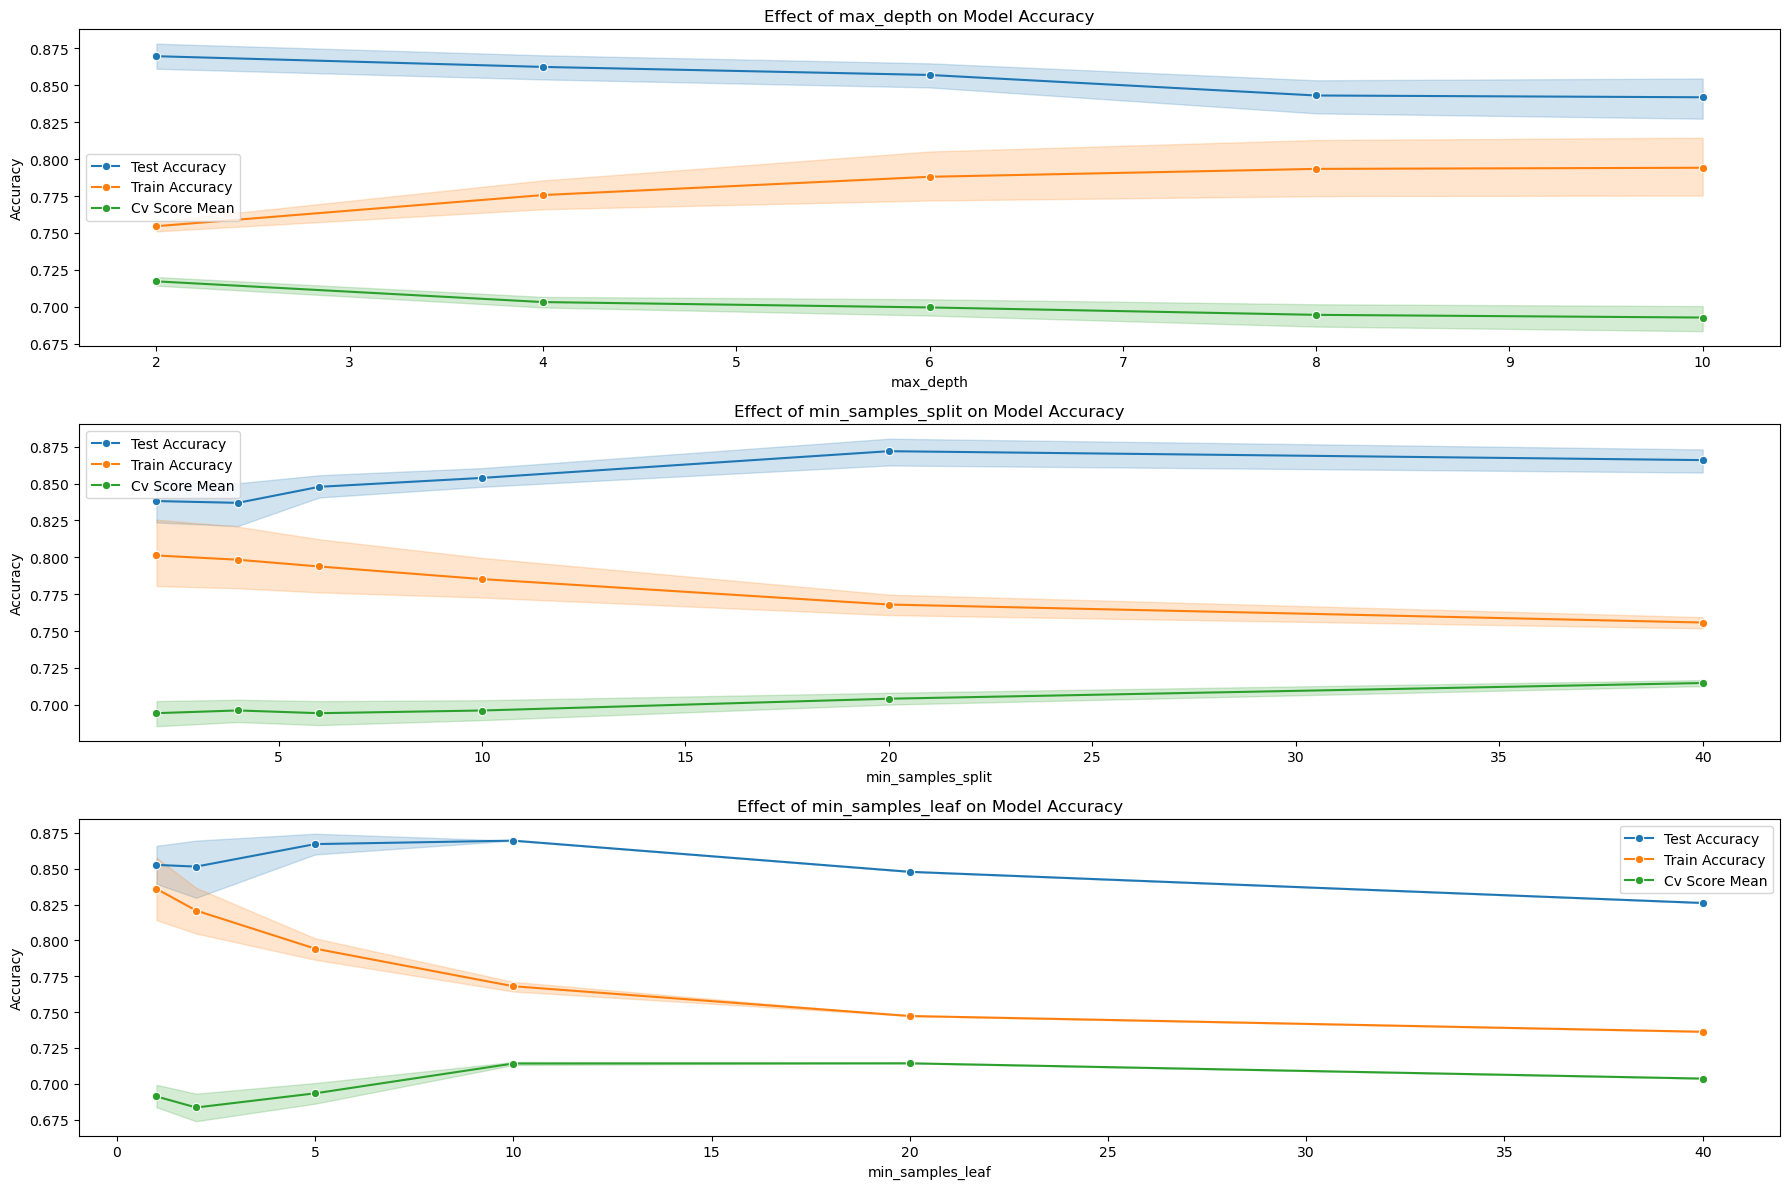

In [60]:
# Define the parameter ranges
max_depth_range = [None, 2, 4, 6, 8, 10]
min_samples_split_range = [ 2, 4, 6, 10, 20, 40]
min_samples_leaf_range = [1, 2, 5, 10, 20, 40]

# Initialize lists to store the results
results = {
    'max_depth': [],
    'min_samples_split': [],
    'min_samples_leaf': [],
    'train_accuracy': [],
    'test_accuracy': [],
    'cv_score': []
}

# Evaluate the model for each combination of parameters
for max_depth in max_depth_range:
    for min_samples_split in min_samples_split_range:
        for min_samples_leaf in min_samples_leaf_range:
            train_acc, cv_score, test_acc = evaluate_model(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            results['max_depth'].append(max_depth)
            results['min_samples_split'].append(min_samples_split)
            results['min_samples_leaf'].append(min_samples_leaf)
            results['train_accuracy'].append(train_acc)
            results['test_accuracy'].append(test_acc)
            results['cv_score'].append(cv_score)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting the results
plt.figure(figsize=(18, 12))

# Plot for max_depth
plt.subplot(3, 1, 1)
sns.lineplot(x='max_depth', y='test_accuracy', data=results_df, marker='o', label='Test Accuracy')
sns.lineplot(x='max_depth', y='train_accuracy', data=results_df, marker='o', label='Train Accuracy')
sns.lineplot(x='max_depth', y='cv_score', data=results_df, marker='o', label='Cv Score Mean')
plt.title('Effect of max_depth on Model Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

# Plot for min_samples_split
plt.subplot(3, 1, 2)
sns.lineplot(x='min_samples_split', y='test_accuracy', data=results_df, marker='o', label='Test Accuracy')
sns.lineplot(x='min_samples_split', y='train_accuracy', data=results_df, marker='o', label='Train Accuracy')
sns.lineplot(x='min_samples_split', y='cv_score', data=results_df, marker='o', label='Cv Score Mean')
plt.title('Effect of min_samples_split on Model Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.legend()

# Plot for min_samples_leaf
plt.subplot(3, 1, 3)
sns.lineplot(x='min_samples_leaf', y='test_accuracy', data=results_df, marker='o', label='Test Accuracy')
sns.lineplot(x='min_samples_leaf', y='train_accuracy', data=results_df, marker='o', label='Train Accuracy')
sns.lineplot(x='min_samples_leaf', y='cv_score', data=results_df, marker='o', label='Cv Score Mean')
plt.title('Effect of min_samples_leaf on Model Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Do grid search to optimize params, we need a larger dataset.

Best parameters found: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score: 0.7142642642642644
Training Accuracy: 0.77
Test Accuracy: 0.87


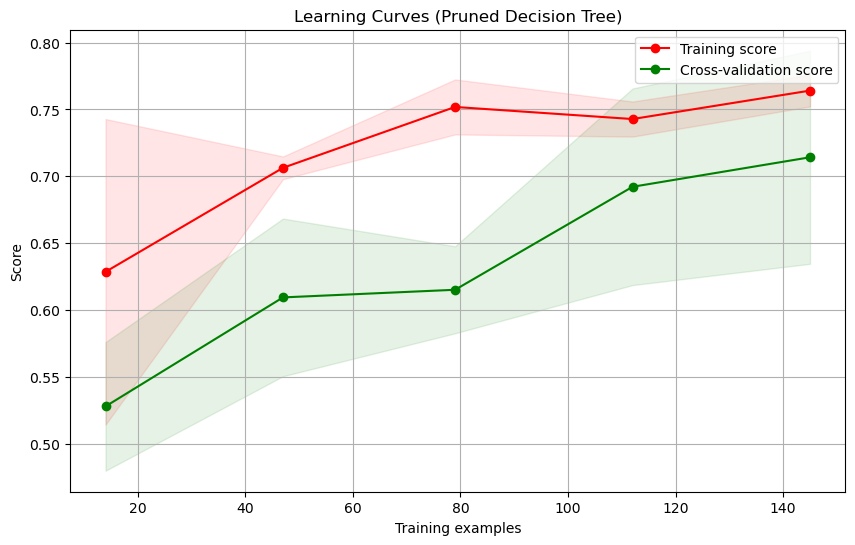

Visualizing the Decision Tree...


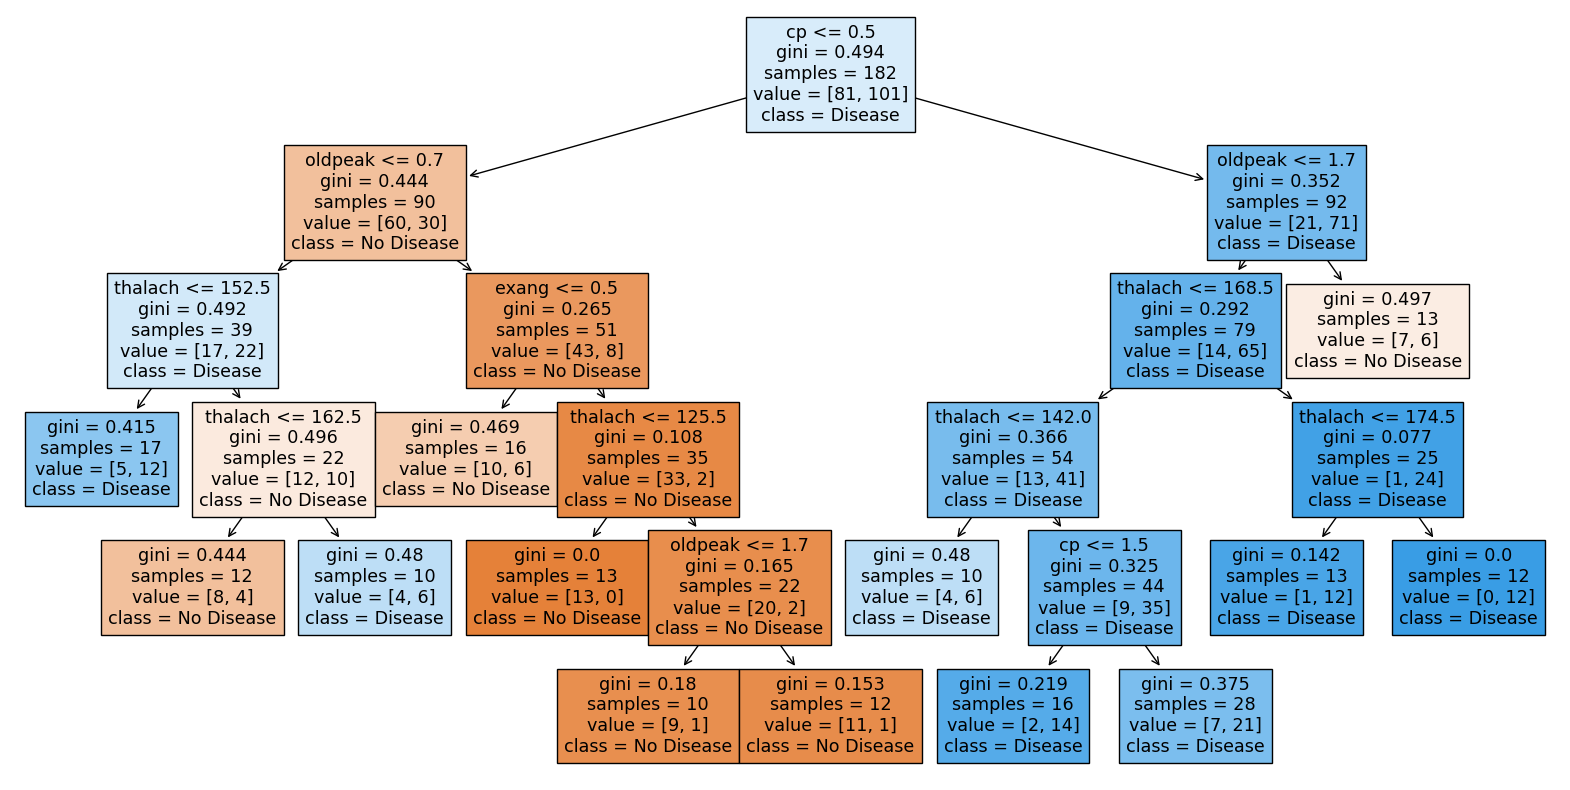

In [64]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
y_pred_train = best_clf.predict(X_train)
y_pred_test = best_clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves for the best model
plot_learning_curve(best_clf, "Learning Curves (Pruned Decision Tree)", X_train, y_train, cv=5, n_jobs=4)
plt.show()

print("Visualizing the Decision Tree...")
plt.figure(figsize=(20,10))
plot_tree(best_clf, filled=True, feature_names=features, class_names=["No Disease", "Disease"])
plt.show()

 plot the learning curve up non optimized DT for comparison purposes

<module 'matplotlib.pyplot' from '/Users/alfred/miniconda3/envs/csc466/lib/python3.12/site-packages/matplotlib/pyplot.py'>

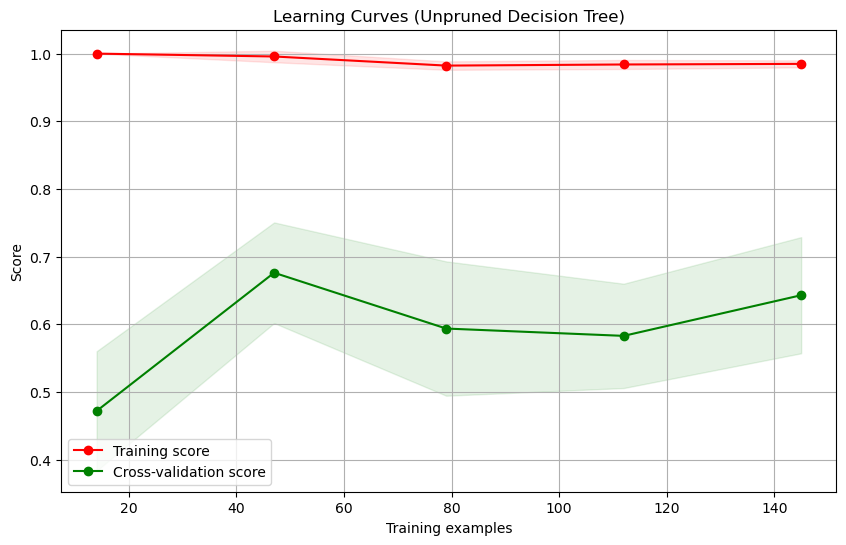

In [62]:
clf = DecisionTreeClassifier(random_state=42)
plot_learning_curve(clf, "Learning Curves (Unpruned Decision Tree)", X_train, y_train, cv=5, n_jobs=4)